In [ ]:
# download the latest version of GraphFrames
!curl -L -o "/usr/local/lib/python3.6/dist-packages/pyspark/jars/graphframes-0.8.2-spark3.2-s_2.12.jar" http://dl.bintray.com/spark-packages/maven/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   164  100   164    0     0   4953      0 --:--:-- --:--:-- --:--:--  5125
100   146  100   146    0     0    789      0 --:--:-- --:--:-- --:--:--   789
curl: (23) Failure writing output to destination


In [ ]:
# install the packages
!pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=e38d480ad67fde4c696f8de22f81783b1b654ca29b361ec96ad745fa46bcc541
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pyspark import SparkConf, SparkContext

conf = SparkConf()
conf.setAppName("MyApp")
conf.set("spark.driver.extraJavaOptions", "-Xss4m")
conf.set("spark.executor.extraJavaOptions", "-Xss4m")

sc = SparkContext(conf=conf)



In [ ]:
import os

os.environ['PYSPARK_SUBMIT_ARGS'] = '--driver-memory 4g --conf spark.driver.extraJavaOptions="-Xss4m" --conf spark.executor.extraJavaOptions="-Xss4m" pyspark-shell'


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType

# Initialize Spark session
spark = SparkSession.builder.appName("LoadDataWithColumnNames").getOrCreate()

# Load features CSV to get column names
features_csv_path = "/content/drive/MyDrive/UNSW-NB15_features.csv"  # Replace with the actual path to your features.csv file

# Try different encodings until the issue is resolved
encodings_to_try = ['utf-8', 'latin-1', 'ISO-8859-1']

features_content = None
for encoding in encodings_to_try:
    try:
        with open(features_csv_path, 'r', encoding=encoding) as file:
            features_content = file.read()
        break  # Break the loop if successful
    except UnicodeDecodeError:
        continue  # Try the next encoding

# If none of the encodings work, you may need to investigate the file's actual encoding.

# Split the content into lines and then into columns
features_lines = features_content.strip().split('\n')
column_info = [line.split(',') for line in features_lines]
print(column_info)
# Construct the schema dynamically
features_schema = StructType([
    StructField(col_info[1], StringType(), True) for col_info in column_info
])

# Load features data with correct delimiter
features_data = spark.read.csv(spark.sparkContext.parallelize([features_content]), sep="\t", header=False, schema=features_schema)

# Extract column names from the features CSV
column_names = features_data.columns

# Load data CSV without header
data_csv_path = "/content/drive/MyDrive/UNSW-NB15.csv"  # Replace with the actual path to your data_dataset.csv file
data = spark.read.csv(data_csv_path, header=False, inferSchema=True)
column_names.pop(0)
# Assign column names to the data DataFrame
for i, col_name in enumerate(column_names):
    data = data.withColumnRenamed("_c{}".format(i), col_name)

# Show the resulting DataFrame with column names
data.show()




[['No.', 'Name', 'Type ', 'Description'], ['1', 'srcip', 'nominal', 'Source IP address'], ['2', 'sport', 'integer', 'Source port number'], ['3', 'dstip', 'nominal', 'Destination IP address'], ['4', 'dsport', 'integer', 'Destination port number'], ['5', 'proto', 'nominal', 'Transaction protocol'], ['6', 'state', 'nominal', '"Indicates to the state and its dependent protocol', ' e.g. ACC', ' CLO', ' CON', ' ECO', ' ECR', ' FIN', ' INT', ' MAS', ' PAR', ' REQ', ' RST', ' TST', ' TXD', ' URH', ' URN', ' and (-) (if not used state)"'], ['7', 'dur', 'Float', 'Record total duration'], ['8', 'sbytes', 'Integer', 'Source to destination transaction bytes '], ['9', 'dbytes', 'Integer', 'Destination to source transaction bytes'], ['10', 'sttl', 'Integer', 'Source to destination time to live value '], ['11', 'dttl', 'Integer', 'Destination to source time to live value'], ['12', 'sloss', 'Integer', 'Source packets retransmitted or dropped '], ['13', 'dloss', 'Integer', 'Destination packets retransmi

In [ ]:
print(column_names)

['Name', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'Sload', 'Dload', 'Spkts', 'Dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat', 'Label']


**Descriptive Statistics**

In [ ]:

# Display descriptive statistics
data.describe().toPandas().transpose()


,0,1,2,3,4
summary,count,mean,stddev,min,max
Name,2539739,None,None,10.40.170.2,59.166.0.9
sport,2539739,30536.93108583205,20441.216792342224,0,65535
dstip,2539739,None,None,10.40.170.2,59.166.0.9
dsport,2539739,11235.096788685767,18438.20083577165,0,65535
proto,2539739,None,None,3pc,zero
state,2539739,None,None,ACC,no
dur,2539739,0.6588634003800393,13.925767633289283,0.0,8786.6377
sbytes,2539739,4340.072263330996,56409.39812286232,0,14355774
dbytes,2539739,36432.01132478574,161105.30400824756,0,14657531


**Correlation**

In [ ]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import pandas as pd

# Assuming 'data' contains numeric features
numeric_cols = [col for col, dtype in data.dtypes if dtype in ['int', 'double']]
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
data_vectorized = assembler.transform(data)

# Calculate correlation matrix
correlation_matrix = Correlation.corr(data_vectorized, "features").head()[0]

# Convert to Pandas DataFrame for better display
correlation_df = pd.DataFrame(correlation_matrix.toArray(), columns=numeric_cols, index=numeric_cols)

# Display the correlation matrix
correlation_df.style.background_gradient(cmap='coolwarm').set_precision(2)


<ipython-input-74-a57135894ac5>:17: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  correlation_df.style.background_gradient(cmap='coolwarm').set_precision(2)


,sport,dsport,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,Sload,Dload,Spkts,Dpkts,swin,dwin,smeansz,dmeansz,trans_depth,res_bdy_len,Sjit,Djit,Stime,Ltime,Sintpkt,Dintpkt,tcprtt,synack,ackdat,is_sm_ips_ports,ct_state_ttl,ct_flw_http_mthd,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,Label
sport,1.00,0.09,-0.02,0.01,0.03,-0.15,0.11,0.02,0.03,-0.11,0.06,0.04,0.04,0.14,0.14,0.02,0.09,0.03,0.01,0.02,0.02,-0.07,-0.07,-0.09,-0.06,0.05,0.04,0.04,-0.06,-0.15,0.03,0.01,0.01,-0.14,-0.14,-0.14,-0.14,-0.16,-0.18,-0.16,-0.15
dsport,0.09,1.00,-0.02,-0.01,-0.01,-0.24,-0.00,0.01,0.00,-0.18,0.51,0.05,0.01,0.39,0.38,-0.04,0.38,-0.14,-0.05,-0.04,-0.09,-0.12,-0.12,-0.04,-0.03,-0.05,-0.04,-0.05,-0.02,-0.20,-0.12,-0.08,-0.07,-0.15,-0.17,-0.20,-0.19,-0.25,-0.25,-0.24,-0.22
dur,-0.02,-0.02,1.00,0.03,0.09,-0.00,0.01,0.04,0.09,-0.01,-0.02,0.09,0.09,0.01,0.01,-0.00,0.04,0.02,0.04,0.03,0.05,-0.01,-0.01,0.07,0.10,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,-0.02,-0.02,-0.01,-0.02,-0.01,-0.01,-0.02,0.00
sbytes,0.01,-0.01,0.03,1.00,0.05,-0.01,0.07,0.95,0.05,-0.02,-0.01,0.60,0.11,0.06,0.06,0.19,0.02,0.00,0.02,0.00,0.00,-0.01,-0.01,-0.00,-0.00,0.03,0.02,0.03,-0.00,-0.00,-0.00,-0.00,-0.00,-0.04,-0.04,-0.03,-0.03,-0.03,-0.03,-0.03,0.01
dbytes,0.03,-0.01,0.09,0.05,1.00,-0.09,0.01,0.12,0.99,-0.07,0.08,0.73,0.97,0.19,0.19,-0.09,0.59,0.12,0.56,0.03,0.13,-0.05,-0.05,-0.01,-0.01,-0.02,-0.02,-0.02,-0.01,-0.08,0.08,-0.03,-0.02,-0.05,-0.05,-0.06,-0.07,-0.07,-0.07,-0.08,-0.08
sttl,-0.15,-0.24,-0.00,-0.01,-0.09,1.00,0.11,-0.07,-0.12,0.28,-0.25,-0.15,-0.14,-0.35,-0.36,-0.06,-0.33,-0.06,-0.04,0.04,-0.07,0.31,0.31,-0.04,-0.03,0.21,0.19,0.20,-0.03,0.91,-0.06,-0.05,-0.04,0.46,0.46,0.39,0.40,0.46,0.48,0.51,0.90
dttl,0.11,-0.00,0.01,0.07,0.01,0.11,1.00,0.08,0.01,-0.22,-0.02,0.05,0.02,0.31,0.31,0.10,0.05,0.12,0.01,0.16,0.05,-0.00,-0.00,-0.03,0.00,0.57,0.52,0.53,-0.03,0.04,0.10,0.03,0.02,-0.30,-0.31,-0.29,-0.28,-0.27,-0.29,-0.29,0.13
sloss,0.02,0.01,0.04,0.95,0.12,-0.07,0.08,1.00,0.15,-0.07,0.05,0.73,0.24,0.19,0.19,0.16,0.09,-0.02,-0.01,0.01,0.02,-0.04,-0.04,-0.01,-0.01,0.02,0.02,0.02,-0.01,-0.06,-0.02,0.03,0.03,-0.08,-0.08,-0.08,-0.08,-0.09,-0.09,-0.09,-0.04
dloss,0.03,0.00,0.09,0.05,0.99,-0.12,0.01,0.15,1.00,-0.09,0.11,0.77,0.99,0.24,0.24,-0.09,0.60,0.10,0.54,0.03,0.12,-0.07,-0.07,-0.02,-0.01,-0.02,-0.02,-0.02,-0.01,-0.10,0.07,-0.00,-0.00,-0.07,-0.07,-0.08,-0.09,-0.09,-0.10,-0.11,-0.10
Sload,-0.11,-0.18,-0.01,-0.02,-0.07,0.28,-0.22,-0.07,-0.09,1.00,-0.17,-0.13,-0.11,-0.36,-0.36,0.06,-0.25,-0.07,-0.03,-0.03,-0.07,0.24,0.24,-0.02,-0.02,-0.04,-0.04,-0.04,-0.01,0.22,-0.06,-0.04,-0.03,0.47,0.48,0.43,0.42,0.47,0.49,0.51,0.19


**Hypothesis Testing:**
Hypothesis testing usually involves comparing means or distributions. However, the specific test depends on your research question or hypothesis. Let's assume you want to compare the means of a numeric column between two groups.

In [ ]:
from scipy.stats import ttest_ind

# Perform t-tests for each numeric attribute
for col in numeric_cols:
    # Filter data for each class
    normal_values = normal_data.select(col).rdd.flatMap(lambda x: x).collect()
    attack_values = attack_data.select(col).rdd.flatMap(lambda x: x).collect()

    # Perform t-test
    t_stat, p_value = ttest_ind(normal_values, attack_values)

    # Print results
    print(f"T-Statistic for {col}: {t_stat}")
    print(f"P-Value for {col}: {p_value}")
    print()


T-Statistic for sport: 241.63624995273835
P-Value for sport: 0.0

T-Statistic for dsport: 353.4832759437183
P-Value for dsport: 0.0

T-Statistic for dur: -3.118874026280416
P-Value for dur: 0.0018154559048992132

T-Statistic for sbytes: -16.21983256466073
P-Value for sbytes: 3.677042544789568e-59

T-Statistic for dbytes: 120.75284101065769
P-Value for dbytes: 0.0

T-Statistic for sttl: -3378.1192504657815
P-Value for sttl: 0.0

T-Statistic for dttl: -217.00184440109214
P-Value for dttl: 0.0

T-Statistic for sloss: 69.04296048029613
P-Value for sloss: 0.0

T-Statistic for dloss: 153.4897296672372
P-Value for dloss: 0.0

T-Statistic for Sload: -312.31375304993645
P-Value for Sload: 0.0

T-Statistic for Dload: 358.9692034527355
P-Value for Dload: 0.0

T-Statistic for Spkts: 194.09854222504507
P-Value for Spkts: 0.0

T-Statistic for Dpkts: 186.06434373075362
P-Value for Dpkts: 0.0

T-Statistic for swin: 529.2894937614468
P-Value for swin: 0.0

T-Statistic for dwin: 527.0739312084994
P-Valu

/usr/local/lib/python3.10/dist-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


**Density Estimation:**

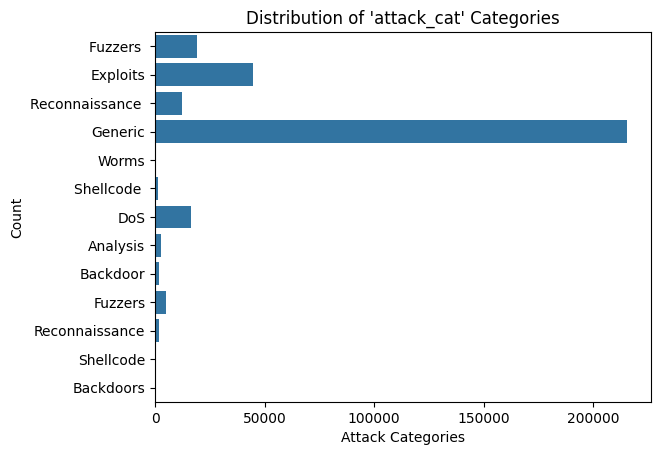

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Bar plot for 'attack_cat' column
sns.countplot(data.select("attack_cat").toPandas()["attack_cat"])
plt.title("Distribution of 'attack_cat' Categories")
plt.xlabel("Attack Categories")
plt.ylabel("Count")
plt.show()


In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Assuming 'data' is your PySpark DataFrame with a 'Label' column
label_column = 'Label'

# Create a VectorAssembler
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")

# Create a StringIndexer for the label column
label_indexer = StringIndexer(inputCol=label_column, outputCol="indexedLabel")

# Create a RandomForestClassifier
rf_classifier = RandomForestClassifier(labelCol="indexedLabel", featuresCol="features")

# Create a Pipeline
pipeline = Pipeline(stages=[assembler, label_indexer, rf_classifier])

# Split the data into training and test sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

# Train the model
model = pipeline.fit(train_data)

# Make predictions on the test set
predictions = model.transform(test_data)

# Evaluate the model
evaluator = BinaryClassificationEvaluator(labelCol="indexedLabel")
area_under_curve = evaluator.evaluate(predictions)
print(f"Area Under ROC Curve: {area_under_curve}")


Area Under ROC Curve: 1.0


In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Assuming 'data' is your PySpark DataFrame with a 'Label' column
label_column = 'Label'

# Create a VectorAssembler
assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")

# Create a StringIndexer for the label column
label_indexer = StringIndexer(inputCol=label_column, outputCol="indexedLabel")

# Combine features and label columns
assembler_label = VectorAssembler(inputCols=["features", "indexedLabel"], outputCol="final_features")

# Create a RandomForestClassifier
rf_classifier_multi = RandomForestClassifier(labelCol="indexedLabel", featuresCol="final_features", numTrees=10)

# Create a Pipeline
pipeline_multi = Pipeline(stages=[assembler, label_indexer, assembler_label, rf_classifier_multi])

# Split the data into training and test sets
train_data_multi, test_data_multi = data.randomSplit([0.8, 0.2], seed=42)

# Train the model
model_multi = pipeline_multi.fit(train_data_multi)

# Make predictions on the test set
predictions_multi = model_multi.transform(test_data_multi)

# Evaluate the model
evaluator_multi = MulticlassClassificationEvaluator(labelCol="indexedLabel", metricName="accuracy")
accuracy_multi = evaluator_multi.evaluate(predictions_multi)
print(f"Accuracy: {accuracy_multi}")


Accuracy: 1.0
